In [ ]:
# cell for importing packages for the first time
# import Pkg; Pkg.add("StaticArrays")
# import Pkg; Pkg.add("Revise")


# import Pkg; Pkg.add("@time")
Pkg.add("FastGaussQuadrature")

In [ ]:
ENV["PYTHON"]=""
import Pkg;
Pkg.add("PyCall")

In [ ]:
Pkg.add("PyPlot")

In [120]:
# using Plots

using StaticArrays
import LinearAlgebra
import FastGaussQuadrature

push!(LOAD_PATH, pwd())

module PhysConst
    export CL,Gr,QE,MSOL,MSUN,ARAD,SGMB,RGAS,
            PC,RSUN,RSUN,YR,MSOLYR,GAM53,KPE,PARSEC,KPE,KPD,M_MW
    CL = 2.997925E10;
    Gr = 6.67384E-8; 
    QE=4.80325E-10;
    MSOL = 1.989E33;
    MSUN = 1.989E33;

    ARAD = 7.56464E-15; 
    SGMB = ARAD*CL/4

    RGAS = 8.31E7; 
    PC = 3.085678E18;
    MP = 1.672661E-24; 
    M_U = 1.660531E-24
    RSOL = 6.95E10
    RSUN = 6.95E10
    YR = 365*24*3600.
    MSOLYR = 1.989e33/YR

    GAM = 5/3.

    KPE = 0.4
    PARSEC=3.0E18
    KPD = 10.

    M_MW=1.

    tst=1

end


#-------------------------------------- STEP 1 -------------------------------------- #
# define necessary data structures

# module SpaceRadGrid

        
# gaussnodes -   Gauss-Legendre nodes
# gaussweights - Gauss-Legendre weights



using StaticArrays
import Base.@kwdef

    const IX = 1
    const IY = 2
    const IZ = 3

    const BIGNUMBER = 10.0^50



    @kwdef struct SGridPar
        

        Nactive = 20;
    
        nghost = 1 #N of ghost cells at every boundary.
            
        Nx = Nactive;   # N of active cells
        Ny = Nactive;
        Nz = Nactive;
        
        Nxtot = Nx +  2*nghost;
        Nytot = Ny +  2*nghost;
        Nztot = Nz +  2*nghost;
    
        is = 1 + nghost; 
        ie = Nxtot -nghost;        

        js = 1 + nghost;  
        je = Nytot - nghost;
        
        ks = 1 + nghost;
        ke = Nztot - nghost;
            
        x1s = -1.
        x1e = 1.
    
        x2s = -1.
        x2e = 1.

        x3s = -1.
        x3e = 1.
        
    end

    @kwdef struct RGridPar
    
        Nfreq = 1 ; # ν - N bins 
        NumPhi = 5
        NumTheta = 5
    
        Nang = NumPhi*NumTheta    
        N_fre_ang = Nfreq*Nang    
    
    
    end


# ------ Init Space and Radiation grids --------------------------------

sg= SGridPar()

@show rad = RGridPar()

@show gaussnodes, gaussweights = FastGaussQuadrature.gausslegendre(rad.NumTheta);

# ----------------------------------------------------------------------



x1 = Array{Float64}(undef, sg.Nxtot)
x2 = Array{Float64}(undef, sg.Nytot)
x3 = Array{Float64}(undef, sg.Nztot)

x1b = Array{Float64}(undef, sg.Nxtot)
x2b = Array{Float64}(undef, sg.Nytot)
x3b = Array{Float64}(undef, sg.Nztot)


@time ir = zeros(Float64, rad.N_fre_ang, sg.Nx, sg.Ny, sg.Nz); # radiation intensity



function MakeXYZstagGrid(x1, x2, x3, x1b, x2b, x3b, sg)  #staggered grid

    # add check sizes
    
    xtmp = range(sg.x1s, sg.x1e; length = sg.Nxtot - 2sg.nghost)
    
#     @show sg.is, sg.ie sg.Nx sg.nghost size(xtmp) size(x1) size(sg.is:sg.ie) size(2:2)
    
    x1[sg.is:sg.ie] .= xtmp[:] 
    x1[sg.is-1] = 2*x1[sg.is]- x1[sg.is+1]
    x1[sg.ie+1] = 2*x1[sg.ie] -x1[sg.ie-1]

    xtmp = range(sg.x2s, sg.x2e; length = sg.Nytot - 2sg.nghost)    

    x2[sg.js:sg.je] .= xtmp[:]     
    x2[sg.js-1] = 2*x2[sg.js]- x2[sg.js+1]
    x2[sg.je+1] = 2*x2[sg.je] -x2[sg.je-1]

    xtmp = range(sg.x3s, sg.x3e; length = sg.Nztot - 2sg.nghost)    

    x3[sg.ks:sg.ke] .= xtmp[:]     
    x3[sg.ks-1] = 2*x3[sg.ks]- x3[sg.ks+1]
    x3[sg.ke+1] = 2*x3[sg.ke] -x3[sg.ke-1]
    
    
    x1b[1] = x1[1] - 0.5(x1[sg.is]-x1[1])    
    for i in sg.is:(sg.ie+1)
        x1b[i] = x1[i-1] + 0.5(x1[i]-x1[i-1])
    end

    x2b[1] = x2[1] - 0.5(x2[sg.js]-x2[1])    
    for j in sg.js:(sg.je+1)
        x2b[j] = x2[j-1] + 0.5(x2[j]-x2[j-1])
    end

    x3b[1] = x3[1] - 0.5(x3[sg.ks]-x3[1])    
    for k in sg.ks:(sg.ke+1)
        x3b[k] = x3[k-1] + 0.5(x3[k]-x3[k-1])
    end
    
    
    
end

mutable struct LongRay1
#     first time calculation of the long ray    
    numOfElm::Int32    
    
#     hed :: Vector{Int32}    
#             dir :: Vector{Float64} 
    
    ijkOfCellCrossed :: Matrix{Int32}        
    xyzPos :: Matrix{Float64}
end


mutable struct RayPair
    
    hed ::Vector{Int32}    
    
    dir::Vector{Float64}    
    
    ray_f:: LongRay1 #forward    
    ray_b:: LongRay1 #backward    
    
end



MakeXYZstagGrid(x1,x2,x3,x1b,x2b,x3b,sg)
@show x3
@show x3b

    
    NumElemInRay = 2*max(sg.Nxtot,sg.Nytot,sg.Nztot)
    
#     arrOfLongRay = Array{LongRay1, 4}(undef, (rad.N_fre_ang, sg.Nxtot, sg.Nytot, sg.Nztot)); 
    
    @time rayPairArr = Array{RayPair, 4}(undef, (rad.N_fre_ang, sg.Nxtot, sg.Nytot, sg.Nztot)); 
    
    


rad = RGridPar() = RGridPar(1, 5, 5, 25, 25)
(gaussnodes, gaussweights) = FastGaussQuadrature.gausslegendre(rad.NumTheta) = ([-0.906179845938664, -0.5384693101056831, 0.0, 0.5384693101056831, 0.906179845938664], [0.23692688505618908, 0.47862867049936647, 0.5688888888888889, 0.47862867049936647, 0.23692688505618908])
  0.000420 seconds (4 allocations: 1.526 MiB)
x3 = [-1.1052631578947367, -1.0, -0.8947368421052632, -0.7894736842105263, -0.6842105263157895, -0.5789473684210527, -0.47368421052631576, -0.3684210526315789, -0.2631578947368421, -0.15789473684210525, -0.05263157894736842, 0.05263157894736842, 0.15789473684210525, 0.2631578947368421, 0.3684210526315789, 0.47368421052631576, 0.5789473684210527, 0.6842105263157895, 0.7894736842105263, 0.8947368421052632, 1.0, 1.1052631578947367]
x3b = [-1.157894736842105, -1.0526315789473684, -0.9473684210526316, -0.8421052631578947, -0.736842105263158, -0.631578947368421, -0.5263157894736842, -0.42105263157894735, -0.3157894736842105, -0.210526

In [124]:
# module RadiationTransfer

x3c = Array{Float64}(undef, 3);
xn = Array{Float64}(undef, 3)
distToNextCell = fill(BIGNUMBER,3) #used in FirstTimeTraceGridOverOneLongRay()
ijk_pos_s = Array{Int32,1}(undef,3)
ijk_pos = Array{Int64}(undef,3)
ijk_max = Array{Int64}(undef,3)
ijk_min = Array{Int64}(undef,3)
ijk_tmp = Array{Int64}(undef,3)

ijk_max .= [ sg.ie+1, sg.je+1, sg.ke+1 ] #max ijk index 
ijk_min .= [ sg.is, sg.js, sg.ks ] #min index
ijk_tmp .= [0, 0, 0]

xbi_zip = [x1b, x2b, x3b]


function FirstTimeTraceGridOverOneLongRay(dir::Vector{Float64}, rayOne::LongRay1, sg::SGridPar)


#     @show dir
    
    dist = 0.0   
    distToNextCell .= BIGNUMBER

    xn .= x3c

    itermax = 2 * sg.Nx

    for iter in 1:itermax #max length, may be smaller than actual

#     @show iter


        for (n_it, norm_i ) in enumerate(dir) #QUESTION: maybe iter over pre-calclulated 1/norms


          xc = x3c[n_it] 

             if iter > 1 

                itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])

                @debug  " debug: (itmp, iter)= " , itmp, iter

                xn[n_it] = xbi_zip[n_it][itmp]                                            


             elseif iter==1 #first step from the middle of the cell

                if norm_i>0                
                   itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])                     
                elseif norm_i <0               
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it]  #belongs to the same index                                
                else                
                    itmp = ijk_pos[n_it]            
                end

                xn[n_it] = xbi_zip[n_it][itmp]

             end


             if norm_i != 0                      
                distToNextCell[n_it] = abs((xn[n_it] - xc)/dir[n_it])
             else
                distToNextCell[n_it]=BIGNUMBER
             end


        #println("iter= ",iter," xn=", xn, " ===> ", "distToNextCell[",n_it,"]=",distToNextCell[n_it])



        end #for loop over norm_i     

            posIndxToUpdate = argmin(distToNextCell)
            dist = distToNextCell[posIndxToUpdate]


        ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] #update only relevant one
    

        #println("ijk_pos[posIndxToUpdate = ", posIndxToUpdate, "]",  "  =  ",   ijk_pos  )


        xn .= x3c + dir*dist
        x3c .= xn

        #update rayOne
        rayOne.numOfElm = iter
        rayOne.ijkOfCellCrossed[:,iter] .= ijk_pos
        rayOne.xyzPos[:,iter] .= xn

#         println("iter=", iter,"  ", "xn= ", xn)

        if ijk_pos[posIndxToUpdate] == ijk_max[posIndxToUpdate] || ijk_pos[posIndxToUpdate] == ijk_min[posIndxToUpdate] || ijk_pos[posIndxToUpdate] == 1 || iter > 100 
            break; 
        end      

    end #over ray

end # FirstTimeTraceGridCalcOneLongRay


function InitRayDirections(rad::RGridPar, sg::SGridPar)
        
#     @show nodes, weights

#     th = range(0, pi; length = rad.NumTheta)
          
    th = zeros(Float64, rad.NumTheta)        
    
    μ = zeros(Float64, rad.NumTheta)        
    
    @show μ .= gaussnodes
    
    ph = range(0, 2pi-pi/rad.NumPhi; length = rad.NumPhi)
    
    @show th, ph
    
    norm = zeros(Float64, rad.Nang, 3);
    

    m=1
    for (i,ph_i) in enumerate(ph)
        for (j,th_j) in enumerate(th)
            
            costh_j = μ[j]
            sinth_j = sqrt(1-μ[j]^2)
            
            norm[m, IX] = sinth_j *sin(ph_i)
            norm[m, IY] = sinth_j *cos(ph_i)                 
            norm[m, IZ] = costh_j
                        
        m+=1;            
        end
    end

    return(norm)
end

norm = InitRayDirections(rad,sg)

function testFirstTimeTraceGridOverOneLongRay(rad::RGridPar, sg::SGridPar)
    dir = norm[rand(1:rad.N_fre_ang),:]
    
    testRay = LongRay1(NumElemInRay, Array{Int32}(undef,3,NumElemInRay),  
        Array{Float64}(undef,3,NumElemInRay) )       
        
    ijk_pos_s[:] = [argmin(abs.(x1.-0.)), argmin(abs.(x2.-0.)), argmin(abs.(x3.-0.))]; 
    ijk_pos_s[:] = [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]    
    ijk_pos .= ijk_pos_s

    ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]                
    x3c .= [ x1[ip], x2[jp], x3[kp] ]
    xyz_s = [ x1[ip], x2[jp], x3[kp] ]
       
    
    FirstTimeTraceGridOverOneLongRay(dir, testRay, sg)     
           
    xyz_e = testRay.xyzPos[:,testRay.numOfElm]                
    dist = LinearAlgebra.norm( xyz_e .- xyz_s)     
    xyz_0e = xyz_s + dir*dist
    
    Δ = LinearAlgebra.norm( xyz_e[:].-xyz_0e[:])/
            LinearAlgebra.norm( xyz_0e[:])
    println("𝐧 = ",  dir)        
        println(" xyz_e= ",  xyz_e)        
        println(" xyz_s= ",  xyz_s)        
        println(" xyz_0e= ",  xyz_0e)            
        println(" dist=", dist)      

    println("|| rend - rs ||/||rs|| = ",  Δ)    
    if Δ <= 1e-5
        println(" Test Passed ! ")    
    else
        error("Test Failed !")
    end
    
end

testFirstTimeTraceGridOverOneLongRay(rad, sg)



μ .= gaussnodes = [-0.906179845938664, -0.5384693101056831, 0.0, 0.5384693101056831, 0.906179845938664]
(th, ph) = ([0.0, 0.0, 0.0, 0.0, 0.0], 0.0:1.413716694115407:5.654866776461628)
𝐧 = [-0.8910065241883678, -0.4539904997395469, 0.0]
 xyz_e= [-1.0526315789473684, -0.2523836281224894, 0.47368421052631576]
 xyz_s= [0.5789473684210527, 0.5789473684210527, 0.47368421052631576]
 xyz_0e= [-1.0526315789473684, -0.2523836281224894, 0.47368421052631576]
 dist=1.831163861403431
|| rend - rs ||/||rs|| = 0.0
 Test Passed ! 


In [127]:


# **************** Trace grid with long rays  ****************** #
    
println("1st time trace grid with long rays, perfom allcoations etc ..")

function TraceGridBothWaysAllocateArr(rad::RGridPar, sg::SGridPar)
    
    dirOld =Array{Float64}(undef,3)
    dirf =Array{Float64}(undef,3)
    dirb =Array{Float64}(undef,3)
    
    testRay_f = LongRay1(NumElemInRay, Array{Int32}(undef,3,NumElemInRay),  Array{Float64}(undef,3,NumElemInRay) )       
    testRay_b = LongRay1(NumElemInRay, Array{Int32}(undef,3,NumElemInRay),  Array{Float64}(undef,3,NumElemInRay) )       
#     @show ijk_pos_s            

    for m=1:rad.N_fre_ang #, ipos=1:sg.Nxtot, jpos=1:sg.Nytot, kpos=1:sg.Nztot

        
        dirf .= norm[m,:]
        dirb .= -norm[m,:]
                        
        ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]
        ijk_pos .= ijk_pos_s        
        
        x3c .= [ x1[ip], x2[jp], x3[kp] ]
        FirstTimeTraceGridOverOneLongRay(dirf, testRay_f, sg)         
        
        ijk_pos .= ijk_pos_s
        x3c .= [ x1[ip], x2[jp], x3[kp] ]
        FirstTimeTraceGridOverOneLongRay(dirb, testRay_b, sg)                                            
        
        # now, when the length of the ray is known, allocate arrOfLongRay[m,i,j,k]
        
        rayPairArr[m,ip,jp,kp] = RayPair(
            Array{Int32,1}(undef,3), 
            Array{Float64,1}(undef,3),

            LongRay1(testRay_f.numOfElm, Array{Int32}(undef,3,testRay_f.numOfElm), 
            Array{Float64}(undef,3,testRay_f.numOfElm)),
            
            LongRay1(testRay_b.numOfElm, Array{Int32}(undef,3,testRay_b.numOfElm), 
            Array{Float64}(undef,3,testRay_b.numOfElm))            
            )
        
        
        
        rayPairArr[m,ip,jp,kp].ray_b.numOfElm = testRay_b.numOfElm  
        rayPairArr[m,ip,jp,kp].ray_f.numOfElm = testRay_f.numOfElm        
       
#       if testRay_b.numOfElm==1            
#           @show m testRay_b.ijkOfCellCrossed[3], 
#                 dirb                    
#       end
        
        
        
        rayPairArr[m,ip,jp,kp].hed .= ijk_pos_s
        
        rayPairArr[m,ip,jp,kp].dir .= dirf

        for iter = 1:testRay_f.numOfElm       
            rayPairArr[m,ip,jp,kp].ray_f.ijkOfCellCrossed[:,iter] .= testRay_f.ijkOfCellCrossed[:,iter]
            rayPairArr[m,ip,jp,kp].ray_f.xyzPos[:,iter] .= testRay_f.xyzPos[:,iter]
        end
# @show testRay_b.numOfElm
        
        for iter = 1:testRay_b.numOfElm       
            rayPairArr[m,ip,jp,kp].ray_b.ijkOfCellCrossed[:,iter] .= testRay_b.ijkOfCellCrossed[:,iter]
            rayPairArr[m,ip,jp,kp].ray_b.xyzPos[:,iter] .= testRay_b.xyzPos[:,iter]
        end
        
#       @show m,ip,jp,kp rayPairArr[m,ip,jp,kp].hed
        
        #         *****
        
#         @show m , x3c , ijk_pos
#         @show testRay_b.numOfElm testRay_f.numOfElm arrOfLongRay[m,ip,jp,kp].numOfElm                
#         display(testRay_b.ijkOfCellCrossed)
#         display(testRay_f.ijkOfCellCrossed)
#         display(arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed)
#         display(testRay_b.xyzPos)
#         display(testRay_f.xyzPos)
#         display(arrOfLongRay[m,ip,jp,kp].xyzPos[:, 4:end ])

        
        
        
        
        
    end
    
end
    


# @time TraceGridBothWaysAllocateArr(rad, sg)
        
# println(" trace grid with long rays done ..")

# **************************************************************#    

1st time trace grid with long rays, perfom allcoations etc ..


TraceGridBothWaysAllocateArr (generic function with 1 method)

<h1>
<b>
Numerical
</b>
</h1>

$$   
 \begin{equation}    
    p\frac{d^2u}{dt^2} = u - S\mbox{,}
 \end{equation}
$$  


<b> Matrix  </b> eq: 
$$
-A_i u_{i-1} + B_i u_{i} -C_i u_{i+1} = S_i
$$

Coefficients have a slightly different form compared to <b>RH91</b> for a slightly better representation of 
the numerical derivative on a staggered grid. The source term allows for implicit contribution from the $b_m u_m$ from $S$. 
 
 $$
 y_i \left(-b_m
    +\frac{p}{\delta \tau _i}
    \left(\frac{1}{\delta \tau _{i+\frac{1}{2}}}+\frac{1}{\delta \tau
   _{i-\frac{1}{2}}}\right)
   +1\right)
   -\frac{p y_{i-1}}{\delta \tau _{i-\frac{1}{2}} \delta \tau _i}
   -\frac{p y_{i+1}}{\delta \tau _i \delta \tau _{i+\frac{1}{2}}}-S_i-S_\beta=0
 $$

Boundary conditions:
    
 $$
 \text{at}\quad t = \tau_1\simeq 0: \quad \alpha \, u'(t) + \beta \, u(t) = \gamma \mbox{,} 
 $$
    
 $$
 \text{at}\quad t = \tau_N: \quad \alpha_1 \, u'(t) + \beta_1 \, u(t) = \gamma_1 \mbox{.} 
 $$


 $$
    i=1:\qquad y_1 \left(\frac{\alpha}{\delta \tau _{\frac{3}{2}}}-\beta\right)-\frac{\alpha y_2}{\delta \tau _{\frac{3}{2}}}+\gamma=0
 $$
 
 $$
 i=N:\qquad
 y_N \left(\frac{\alpha_1}{\delta \tau _{N-\frac{1}{2}} }+\beta_1\right)-\frac{\alpha_1 y_{N-1}}{\delta \tau _{N-\frac{1}{2}} }=0
$$
 
<h>
    <b> Source function: </b>   
</h>
$$ 
S_{i}=\alpha\,\Sigma_{n}^{N_{\nu}}a_{n}\phi_{in}\,\Sigma_{m=1}^{N_{m}}b_{m}u_{imn}
$$ 
    

In [215]:
function ProgonRybHumAlongTheRay(ray::LongRay1, sg::SGridPar, rad::RGridPar)

    Nmat = ray.numOfElm
    
    u = zeros(Float64, Nmat)
    
    A = zeros(Float64, Nmat)
    B = zeros(Float64, Nmat)    
    C = zeros(Float64, Nmat)
    D = zeros(Float64, Nmat)
    Z = zeros(Float64, Nmat)
    S = zeros(Float64, Nmat) #Rhs

    p=1
    alph = 1.
    bet = -1.
    gam = 0
    alph1 = 1.
    
    bet1 = 1.
    gam1 = 1.
    
    Sd = 2.
    Sbet =1.
    bm = 0
    
    dx_i = LinearAlgebra.norm(ray.xyzPos[:,2].-ray.xyzPos[:,1]) 
    dx_ip05 = dx_i
    
    A[1] = 0.
    B[1] = -bet + alph/dx_ip05
    C[1] = alph/dx_ip05
    S[1] = -gam
    D[1] = C[1]/B[1]
    Z[1] = S[1]/B[1]
    
    C[Nmat]=0.
    
    for i = 2 : Nmat-1 #forward                        

        dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])                  
        dx_im05 = dx_i         
        dx_ip05 = dx_i  
        S[i] = Sd+Sbet
        
        A[i] = p /(dx_i*dx_im05)         
        B[i] = 1. - bm + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i        
        C[i] = p/(dx_i*dx_ip05)  
                        
        k1 = 1/(B[i] - A[i]D[i-1])        
        D[i] = k1*C[i]        
        Z[i] = k1*( S[i]  + A[i]*Z[i-1])                     
    end 

    dx_im05 = dx_i         
    dx_ip05 = dx_i 
    S[Nmat] = gam1
    
    C[Nmat]=0.
    D[Nmat]=0.

    A[Nmat] = (alph1/dx_im05)
    B[Nmat] = bet1 + alph1/dx_im05
    
    k1 = 1/(B[Nmat] - A[Nmat]*D[Nmat-1])
    
    Z[Nmat] = k1*( S[Nmat]  + A[Nmat]*Z[Nmat-1])                     
    u[Nmat] = Z[Nmat]
    
    for i = Nmat-1:-1:1  #backsweep

        u[i] = D[i]u[i+1]+Z[i]
        
    end #for                    
    
    return(u)
end #RTAlongTheRay

function ProgonRybHumAlongTheRayAppndxA(ray::LongRay1, sg::SGridPar, rad::RGridPar)
    
    Nmat = ray.numOfElm
#     @show Nmat
    u = zeros(Float64, Nmat)
        
    D = zeros(Float64, Nmat)
    H = zeros(Float64, Nmat)
    F = zeros(Float64, Nmat)
    Z = zeros(Float64, Nmat)    

    p=1
    alph = 1.
    bet = -1.
    gam = 0
    alph1 = 1.
    
    bet1 = 1.
    gam1 = 1.
    
    Sd = 2.
    Sbet =1.
    bm = 0
    
    dx_i = LinearAlgebra.norm(ray.xyzPos[:,2].-ray.xyzPos[:,1]) 
    dx_ip05 = dx_i
    
    
    B1 = -bet + alph/dx_ip05
    C1 = alph/dx_ip05
    S1 = -gam

    H[1] = B1-C1    
    F[1] = H[1]/C1
    Z[1] = S1/B1    
    
    
    for i = 2 : Nmat-1 #forward                        

        dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])                  
        dx_im05 = dx_i         
        dx_ip05 = dx_i  
        Si = Sd+Sbet
        
        Ai = p /(dx_i*dx_im05)         
        Bi = 1 - bm + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i        
        Ci = p/(dx_i*dx_ip05)  

        H[i] = -Ai + Bi - Ci                
        F[i]=(H[i]+(Ai*F[i-1])/(1+F[i-1]))/Ci        
        Z[i]=(Si+Ai*Z[i-1])/(1+F[i])/Ci      
        
    end 

    dx_im05 = dx_i         
    dx_ip05 = dx_i 
    SN = gam1
    
    CN=0.
    AN = (alph1/dx_im05)
    BN = bet1 + alph1/dx_im05
    
    Dnm1 = 1/(1+F[Nmat-1])    
    Z[Nmat] = (SN+AN*Z[Nmat-1])/( BN - AN*Dnm1)                         
    u[Nmat] = Z[Nmat]

    for i = Nmat-1:-1:1  #backsweep

        u[i] = u[i+1]/(1+F[i]) + Z[i]
        
    end #for                    
    println("... ProgonRybHumAlongTheRayAppndxA done")
    return(u)
    
end #RTAlongTheRay


# tests
function TestRybHumAlongTheRay()
    # pick a ray
    ray =  rayPairArr[rand(1:rad.N_fre_ang), ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_f    
    u1 = ProgonRybHumAlongTheRay(ray, sg, rad)
    u = ProgonRybHumAlongTheRayAppndxA(ray, sg, rad);    
#     @show u1 u
    Δ=LinearAlgebra.norm((u-u1)./u1)
    println( "relative difference between ProgonRybHumAlongTheRayAppndxA 
        and ProgonRybHumAlongTheRay:\n Δu/u=", Δ )    

    if Δ <= 1e-2
        println(" Test Passed ! ")    
    else
        error( " Test Failed !")
    end
end

TestRybHumAlongTheRay()

... ProgonRybHumAlongTheRayAppndxA done
relative difference between ProgonRybHumAlongTheRayAppndxA 
        and ProgonRybHumAlongTheRay:
 Δu/u=2.276044085666509e-15
 Test Passed ! 


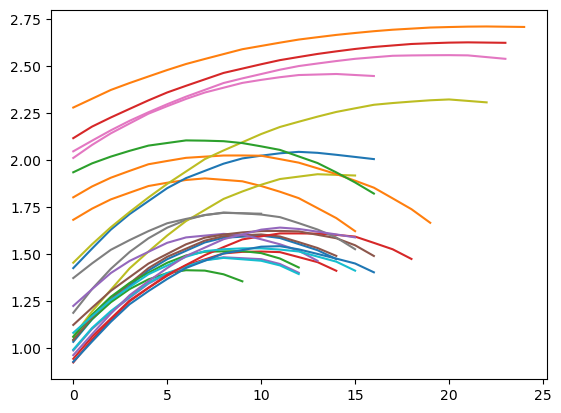

... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done
... ProgonRybHumAlongTheRayAppndxA done


In [210]:
#  using PyPlot 
# using Plots
# gr() 


using Plots
import GR
gr()

function RTSolveTwoWayRay(RayIndex::Int64)        
   
   
    
    # pick a ray
    rayf =  rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_f
    uf  = ProgonRybHumAlongTheRayAppndxA(rayf, sg, rad); #forward
    
    
#     @show RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]
    # @show rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].dir

  
    #     change direction                
     rayb =  rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_b
     ub  = ProgonRybHumAlongTheRayAppndxA(rayb, sg, rad); #backward
    
    
    
# plot(layout=(2,2))
    p1 = plot(ub);    
#     p2 = plot(uf);
    
end 


    
ijk_pos_s[:] = [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]
    
ijk_pos_s[:] = [argmin(abs.(x1.-0.)), argmin(abs.(x2.-0.)), argmin(abs.(x3.-0.))];   



TraceGridBothWaysAllocateArr(rad, sg)

for m=1:rad.N_fre_ang 
    RTSolveTwoWayRay(m)
end


<h1>
    <b>
   Schwarzschild-Schuster 2BV problem:
    </b>
    
</h1>

<!-- <font size="4"> -->



$$   
 \begin{equation}    
    p\frac{d^2u}{dt^2} = u - S\mbox{,}
 \end{equation}
$$  
where $t=\tau$, $p=\mu^2 = const$, $S=const$
    
Boundary conditions:
    
 $$
 \text{at}\quad t = \tau_1\simeq 0: \quad \alpha \, u'(t) + \beta \, u(t) = \gamma \mbox{,} 
 $$
    
 $$
 \text{at}\quad t = \tau_N: \quad \alpha_1 \, u'(t) + \beta_1 \, u(t) = \gamma_1 \mbox{.} 
 $$
Source function in SS-approximation:
\begin{equation}
    S(t) = \frac{1}{2}\left( I^{+}(t) + I^{-}(t) \right)\equiv u(t)
\end{equation}


<!-- </font> -->


In [ ]:
function DensMatrixSolvAlongTheRay(xGrid, rayOne::LongRay1, sg::SGridPar, rad::RGridPar)
    
    
    Nn = rad.Nfreq; # ν - N bins 
    Nd = rayOne.numOfElm; # x - bins 
    Nmat = Nd*Nn
    
    Mat = zeros(Float32, Nmat, Nmat)
    Rhs = zeros(Float32, Nmat) #right side    
    
    alph = 1.
    bet = -1.
    gam = 0

    alph1 = 1.
    
    bet1 = 1.
    gam1 = 1.

    Sd = 2.
    Sbet =1.
    bm = 1.
    
    p=1.


    for i = 1:Nmat
        for i = 1:Nmat

            iSubMatRaw = div(i + Nn-1, Nn)         

            if iSubMatRaw == 1 
                Rhs[i] = -gam                   
            elseif iSubMatRaw == Nd 
                Rhs[i] = gam1
            else
                Rhs[i] = Sd+Sbet
            end


            for j = 1:Nmat


            jSubMatCol = div(j + Nn-1, Nn)

            iloc = i - Nn * (iSubMatRaw-1)        
            jloc = j - Nn * (jSubMatCol-1)

            if iSubMatRaw == 1 #left BC    


                dx_i = xGrid[2]-xGrid[1]
                dx_im05 = dx_i 
                dx_ip05 = dx_i        
                fPar = [dx_im05, dx_i, dx_ip05, 1]

                if jSubMatCol == 1
                    B1 = -bet + alph/dx_ip05

                    Mat[i,j] = iloc==jloc ? B1 : 0 #only diag    

                elseif jSubMatCol == 2

                    C1 = -alph/dx_ip05

                    Mat[i,j] = iloc==jloc ? C1 : 0

                end                        

            elseif iSubMatRaw > 1 && iSubMatRaw < Nd
    #           the main body of the matrix

                dx_i = xGrid[iSubMatRaw+1]-xGrid[iSubMatRaw]
                dx_im05 = dx_i 
                dx_ip05 = dx_i

                    if iSubMatRaw == jSubMatCol  && iloc==jloc
#                         B = 1 + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i
                        
                        B = 1 - bm + ((1/dx_im05 + 1/dx_ip05)*p)/dx_i
                        
                        Mat[i,j] = B
                    elseif iSubMatRaw == jSubMatCol+1 && iloc==jloc                     
                        A =  -p /(dx_i*dx_im05)                     
                        Mat[i,j] = A                    
                    elseif iSubMatRaw == jSubMatCol-1                    
                        C=-(p/(dx_i*dx_ip05))                                        
                        Mat[i,j] = C
                    else                                        
                        Mat[i,j] = 0                                                        
                    end


            elseif iSubMatRaw == Nd #right BC                
                dx_i = xGrid[Nd]-xGrid[Nd-1]
                dx_im05 = dx_i 
                dx_ip05 = dx_i

                if jSubMatCol == Nd-1

                    AN = -(alph1/dx_im05)

                    Mat[i,j] = iloc==jloc ? AN : 0

                elseif jSubMatCol == Nd

                    BN = bet1 + alph1/dx_im05

                    Mat[i,j] = iloc==jloc ? BN : 0

                end

            end

            end


        end
    end

# end

    display(Mat)
    # display(Rhs)
    # @show Rhs
    Mat_inv = inv(Mat)
    # Mat_inv*Mat

    ytestNumeric1 = Mat_inv*Rhs

    
    
    end  #RTFotrieAlongTheRay

    
function SchwarzSchustRT()

        ray = arrOfLongRay[1, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]
    
        @show  ray.dir
                    
        tauGrid = range(0., 1; length = ray.numOfElm)    
        #typeof(tauGrid)
    
    
        DensMatrixSolvAlongTheRay(tauGrid, ray, sg, rad)
    

    
end



SchwarzSchustRT()


In [ ]:

# module RadTransfer
    

# ijk_pos = Array{Int64}(undef,3)
# ijk_max = [ sg.ie+1, sg.je+1, sg.ke+1 ] #max ijk index 
# ijk_min = [ sg.is, sg.js, sg.ks ] #min index

# distToNextCell = fill(BIGNUMBER,3) #used in FirstTimeTraceGridOverOneLongRay()


# norm[1, IX, :, :, :] .=  1
# norm[1, IY, :, :, :] .= -1
# norm[1, IZ, :, :, :] .= -1


# iOf_0 = argmin(abs.(x1)); jOf_0 = argmin(abs.(x2)); kOf_0 = argmin(abs.(x3))
# # ijk_pos .= [sg.is, sg.js, sg.ks]
# # ijk_pos .= [iOf_0, div(sg.je,2), div(sg.ke,2)]
# # ijk_pos .= [sg.ie, sg.je, sg.ke]

# ijk_pos .= [iOf_0,  jOf_0,  kOf_0]
# ijk_tmp = [0, 0, 0]



# rayOne.dir .= [norm[1, IX, 1, 1, 1], norm[1, IY, 1, 1, 1] , norm[1, IZ, 1, 1, 1]]


# rayOne.dir=LinearAlgebra.normalize(rayOne.dir)

# @show rayOne.dir
# @show ijk_pos

# xbi_zip = [x1b, x2b, x3b]



# x3c = [ x1[ijk_pos[IX]], x2[ijk_pos[IY]], x3[ijk_pos[IZ]] ]

# # @show x3c
# # @show x1
# # @show x1b

# # @show x2
# # @show x2b

# # @show x3
# # @show x3b

# # @show xbi_zip[2]


# FirstTimeTraceGridOverOneLongRay(rayOne, sg)







# end #module RadTransfer

In [ ]:
#-------------------------------------- STEP 2 -------------------------------------- #



# @show size(norm);



In [ ]:
# logger=Logging.SimpleLogger(stderr,Logging.Debug)

function TestOneRay(ray, sg)
    xyz_s=Vector{Float64}(undef,3)    
    xyz_e=Vector{Float64}(undef,3)    
    xyz_0e=Vector{Float64}(undef,3)
    
    xyz_s .= ray.xyzPos[:,1]
    
    xyz_e = ray.xyzPos[:,ray.numOfElm]

    dist =LinearAlgebra.norm( xyz_e[:].-xyz_s[:]) 
    
    xyz_0e = xyz_s + ray.dir*dist
    
    
    @show xyz_e, xyz_0e, dist
    
    println("|| rend - rs || = ",  LinearAlgebra.norm( xyz_e[:].-xyz_0e[:]) )
    
end


TestOneRay(rayOne, sg)



In [ ]:
module debugByPlot

using Plots
# x= LinRange(0,30,10)

# import 

x = [0.5, 1.]
y = [0., 1.]
z = [0., 0.1];


plt=plot3d(x,y,z)



end


In [ ]:
ray = arrOfLongRay[rand(1:rad.Nang), ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]


function PlotRay(ray, sg)
    
    x = ray.xyzPos[1,1:ray.numOfElm]
    y = ray.xyzPos[2,1:ray.numOfElm]   
    z = ray.xyzPos[3,1:ray.numOfElm]      
    
    @show ray.numOfElm,x,y,z

    plot3d(x,y,z,
        xlabel = "x", ylabel = "y", zlabel = "z", 
        xlim= (sg.x1s,sg.x1e),ylim= (sg.x2s,sg.x2e),zlim= (sg.x3s,sg.x3e))    
end



# plt=PlotRay(rayOne, sg); display(plt)    
# display(plt)    
# inline()
# end #module RadiationTransfer

# function xyzToijk(xin::Float64, yin::Float64, zin::Float64, x1::Array{Float64,1}, x2::Array{Float64,1},x3::Array{Float64,1})
#     i = argmin( abs.(x1 .-xin )); 
#     j = argmin(abs.(x2.-yin)); 
#     k = argmin(abs.(x3.-zin))    
#     return(i,j,k)
# end

# typeof(x1)

    
i = argmin(abs.(x1.-0.)); 


# GetIndxGiveCoords1(0., 0., 0., x1, x2, x3)

    
@show ijk_pos_s ray.dir

plt=plot3d(ray.xyzPos[1,1:ray.numOfElm],
        ray.xyzPos[2,1:ray.numOfElm],
        ray.xyzPos[3,1:ray.numOfElm],
        xlabel = "x", ylabel = "y", zlabel = "z", 
        xlim= (sg.x1s,sg.x1e),ylim= (sg.x2s,sg.x2e),zlim= (sg.x3s,sg.x3e))

 
display(plt)
# function xyzToijk(xin::Float64, yin::Float64, zin::Float64, x1::Array{Float64,1}, x2::Array{Float64,1},x3::Array{Float64,1})
#     i = argmin( abs.(x1 .-xin )); 
#     j = argmin(abs.(x2.-yin)); 
#     k = argmin(abs.(x3.-zin))    
#     return(i,j,k)
# end

# typeof(x1)

    
# i = argmin(abs.(x1.-0.)); 


# GetIndxGiveCoords1(0., 0., 0., x1, x2, x3)



# function mtest()
# L = M = N = Int(5e2);

# vec_vec_vec = Array{Array{Vector}}(L);

# for i = 1:L vec_vec_vec[i] = [zeros(N) for j = 1:M] end;

# vec_mat = Array{Matrix}(L);

# fill!(vec_mat, rand(M, N));

# arr = rand(L, M, N);

# @time  for i = 1:L for j = 1:M for k = 1:N vec_vec_vec[i][j][k] += 1; end; end; end; 

# @time  for i = 1:L for j = 1:M for k = 1:N vec_mat[i][j,k] += 1; end; end; end; 

# @time  for k = 1:N for j = 1:M for i = 1:L arr[i,j,k] += 1; end; end; end; 

# end
# mtest()



# mutable struct SegmentData{
#  /*! cell data along the trajectory */
#   /*!  current index of cell along the ray, phi index is the same */
#   /*! if the source is symmetrical */
#   int i,k;    
#   float dl; //length element    
# }SegmentData;

# RayCellInd1 = Array{Int32}(undef,1)
# RayCellInd2 = Array{Int32}(undef,1)
# RayCellInd3 = Array{Int32}(undef,1)
# push!(RayCellInd1, 1)
# RayCellInd1 .=0
# RayCellInd2 .=0
# RayCellInd3 .=0


# create array of ray directions, mu, for every ijk cell (nx,ny,nz) components
# for every ray; 
# nang - number of rays per cell 



# RayData = Array of ( (iCross, jCross, kCross), NcrossCells,(istart, jstart, kstart)=3)
# NcrossCells=3
# @time RayData = zeros(3,  zeros(3),  3)



